# Mapping drought indicator - SPEI VERSION


A simple accepted measure for drought is the Standardized Precipitation Index (SPEI).



https://www.meteoswiss.admin.ch/home/climate/swiss-climate-in-detail/climate-indicators/drought-indices/spi-and-spei.html


In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from scipy import stats

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [3]:
# import hvplot.xarray

In [16]:
def area_of_pixel(pixel_size, center_lat):
    """Calculate m^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in m^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)
    area_list = []
    for f in [center_lat + pixel_size/2, center_lat - pixel_size/2]:
        zm = 1 - e*np.sin(np.radians(f))
        zp = 1 + e*np.sin(np.radians(f))
        area = (np.pi * b**2 * (
                np.log(zp/zm) / (2*e) +
                np.sin(np.radians(f)) / (zp*zm)))
        
        area_list.append(area)
    return (pixel_size / 360.) * (area_list[0] - area_list[1])

In [15]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.figsize'] = (5, 2.7)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['savefig.bbox'] = 'tight'

In [12]:
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

#CRU data is one year behind ERA5
MAX_YEAR = 2018

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'

RESULTS_FOLDER = Path('./results/drought')

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'drought'/ 'results_2020'

# 'Severity X or worse'
# MODERATE_DROUGHT_THRESHOLD = -1
# SEVERE_DROUGHT_THRESHOLD = -1.5
# EXTREME_DROUGHT_THRESHOLD = -2

MILD_DROUGHT_THRESHOLD = -0.5
MODERATE_DROUGHT_THRESHOLD = -0.8
SEVERE_DROUGHT_THRESHOLD = -1.3
EXTREME_DROUGHT_THRESHOLD = -1.6
EXCEPTIONAL_DROUGHT_THRESHOLD = -2

DROUGHT_THRESHOLDS = [MILD_DROUGHT_THRESHOLD, MODERATE_DROUGHT_THRESHOLD, SEVERE_DROUGHT_THRESHOLD, EXTREME_DROUGHT_THRESHOLD, EXCEPTIONAL_DROUGHT_THRESHOLD]

DROUGHT_THRESHOLDS_NAMES = ['MILD DROUGHT', 'MODERATE DROUGHT','SEVERE DROUGHT','EXTREME DROUGHT', 'EXCEPTIONAL DROUGHT']

SPEI_INPUT_FILE = INTERMEDIATE_RESULTS_FOLDER / 'spei01.nc'


In [13]:
MAP_PROJECTION = ccrs.EckertIII()

In [14]:
def plot_events_map(plot_data, ax=None):
    plot_data = plot_data.where(plot_data > 0)
    plot_data.name = 'N droughts'

    if ax is None:
        f, ax = plt.subplots(subplot_kw=dict(projection=MAP_PROJECTION), constrained_layout=True)
    
    plot_data.plot.pcolormesh(
        cmap='plasma',
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal','label':''},
        ax=ax
    )
    ax.coastlines()
    return ax

# Load SPEI data

In [17]:
spei = xr.open_dataarray(SPEI_INPUT_FILE,
                         chunks={'time': 12}
                        )

In [18]:
spei

<xarray.DataArray 'spei' (time: 1416, lat: 360, lon: 720)>
dask.array<open_dataset-b5b347d55d55d211e4238b085b920d9aspei, shape=(1416, 360, 720), dtype=float32, chunksize=(12, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2018-12-16
Attributes:
    units:      z-values
    long_name:  Standardized Precipitation-Evapotranspiration Index

In [19]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(spei.lat))

# Get a land mask that matches the coord system of the CRU data

In [20]:
# The ERA coord system doesn't match SPEI. Could maybe go back to the original GPWv4 codes?
# COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'
# COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()
# mask = (COUNTRIES_RASTER.country_codes < 9999)

In [21]:
# For now just take the cells where spei is finite
mask = np.isfinite(spei.isel(time=10, drop=True)).rename({'lat': 'latitude', 'lon': 'longitude'}).load()


# Calculate the number of months where the SPI dropped below the threshold for drought

- Consider the incidences of 'Severe' drought (SPI< -1.5) and 'Extreme' drought (SPI < -2)


In [22]:
def calc_droughs(spi):
    drought_counts = xr.concat(
        [spi < threshold for threshold in DROUGHT_THRESHOLDS],
        dim=pd.Index(DROUGHT_THRESHOLDS, 
                     name='spei_threshold')
    )
    drought_counts = (drought_counts
                      .groupby('time.year')
                      .sum(dim='time')
                      .astype(np.float32)
                      .compute()
                      .rename({'lat': 'latitude', 'lon': 'longitude'})
                      .assign_coords(drought_severity=('spei_threshold', 
                                                       DROUGHT_THRESHOLDS_NAMES
                                                      ))
                     )
    drought_counts.name = 'N droughts'
    return drought_counts

## Apply to SPEI

In [29]:
drought_counts = calc_droughs(spei)

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


In [30]:
drought_counts = drought_counts.where(mask)

In [31]:
drought_counts = drought_counts.reindex(latitude=list(reversed(drought_counts.latitude)))

In [32]:
drought_counts

<xarray.DataArray 'N droughts' (spei_threshold: 5, year: 118, latitude: 360, longitude: 720)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., na

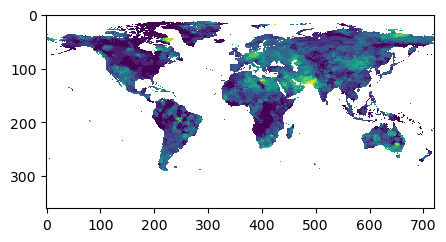

In [33]:
# Double check the underlying data orientation is correct by comparing the
# XR plot with the raw data plot
plt.imshow(drought_counts.isel(year=-1, spei_threshold=1).data)

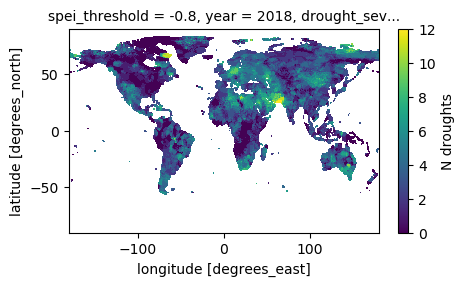

In [19]:
drought_counts.isel(year=-1, spei_threshold=1).plot()

In [34]:
# # Calculate grid cell areas
# delta_lon = spi6.lon[1] - spi6.lon[0]
# earth_radius = 6371

# areas = (np.sin(np.radians(spi6.lat.values + 0.25))
#  - np.sin(np.radians(spi6.lat.values - 0.25))) * (np.radians(delta_lon.values)) * earth_radius**2



# Areas in km2 - calculation is in m2
areas = area_of_pixel(0.5, drought_counts.latitude.values) / (1000*1000)
areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': drought_counts.latitude})

In [35]:
# Calculate total earth surface area using same pixel definition
total_earth_area = (len(drought_counts.longitude) * areas.sum()).item()

In [36]:
total_land_area = (mask * areas).sum().item()

In [37]:
total_land_area

144179977.00422126

In [38]:
# Its a bit off :/
(total_land_area / total_earth_area)

0.28266946617095273

## Map plot combined drought counts

> Select just a few years for example

In [28]:
# # Manually select a few years since 1901 to plot
# years = [1901, 1950, 1980, 1986, 2000, 2005, 2010, MAX_YEAR]

# (drought_counts.sel(year=years, spei_threshold=[SEVERE_DROUGHT_THRESHOLD, EXTREME_DROUGHT_THRESHOLD])
#  .hvplot(
#     'longitude', 'latitude', 
#     projection=MAP_PROJECTION, 
#      coastline=True,
#     project=True, global_extent=True, 
#     cmap='plasma', 
# #     rasterize=True, 
#     dynamic=True, 
#     frame_width=500,
# #     levels=12,
# #     clim=(0,12)
# ))

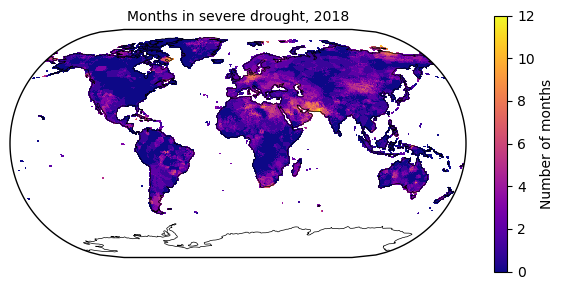

In [75]:
f = plt.figure(figsize=(6,3))

plot_data = drought_counts.sel(year=2018, spei_threshold=SEVERE_DROUGHT_THRESHOLD)

ax = plt.axes(projection=MAP_PROJECTION)

plot_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
#     add_colorbar=False,
    cbar_kwargs=dict(label='Number of months'),
        cmap='plasma',
    vmin=0, vmax=12
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Months in severe drought, {MAX_YEAR}')
plt.tight_layout()

f.savefig(RESULTS_FOLDER/ f'map_spei_severe_drought_count_{MAX_YEAR}.png')
f.show()


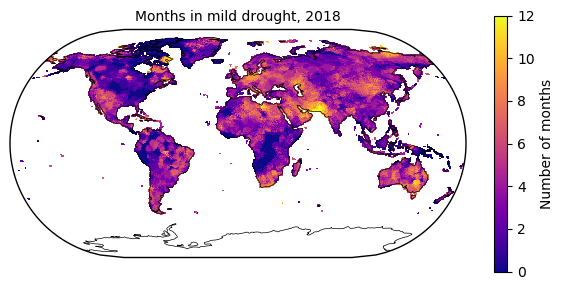

In [104]:
f = plt.figure(figsize=(6,3))

plot_data = drought_counts.sel(year=2018, spei_threshold=MILD_DROUGHT_THRESHOLD)

ax = plt.axes(projection=MAP_PROJECTION)

plot_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
#     add_colorbar=False,
    cbar_kwargs=dict(label='Number of months'),
        cmap='plasma',
    vmin=0, vmax=12
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Months in mild drought, {MAX_YEAR}')
plt.tight_layout()

# f.savefig(RESULTS_FOLDER/ f'map_spei_severe_drought_count_{MAX_YEAR}.png')
f.show()


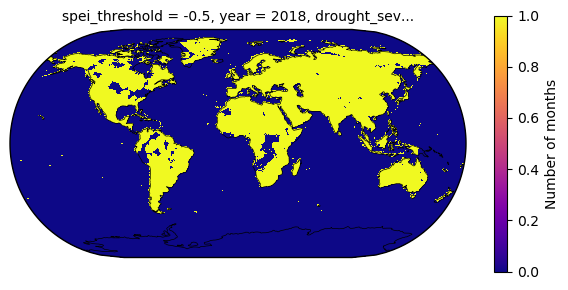

In [110]:
f = plt.figure(figsize=(6,3))

plot_data = (drought_counts > 0).astype(int).sel(year=2018, spei_threshold=MILD_DROUGHT_THRESHOLD)

ax = plt.axes(projection=MAP_PROJECTION)

plot_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='Number of months'),
        cmap='plasma',
    vmin=0, vmax=1
)
ax.coastlines(linewidth=0.5)
# ax.set(title=f'Months in mild drought, {MAX_YEAR}')
plt.tight_layout()

# f.savefig(RESULTS_FOLDER/ f'map_spei_severe_drought_count_{MAX_YEAR}.png')
f.show()


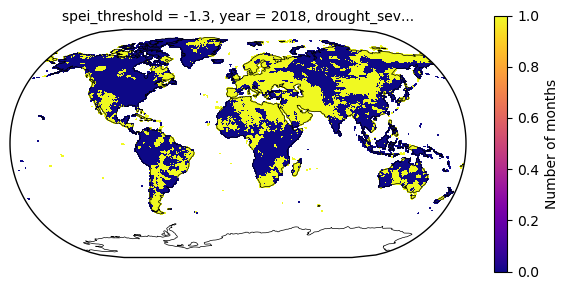

In [113]:
f = plt.figure(figsize=(6,3))

plot_data = (drought_counts > 1).astype(int).sel(year=2018, spei_threshold=SEVERE_DROUGHT_THRESHOLD).where(mask)

ax = plt.axes(projection=MAP_PROJECTION)

plot_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='Number of months'),
        cmap='plasma',
    vmin=0, vmax=1
)
ax.coastlines(linewidth=0.5)
# ax.set(title=f'Months in mild drought, {MAX_YEAR}')
plt.tight_layout()

# f.savefig(RESULTS_FOLDER/ f'map_spei_severe_drought_count_{MAX_YEAR}.png')
f.show()


## % area in Drought counts SPEI

In [27]:
(drought_counts > 0).astype(int).where(mask).max()

<xarray.DataArray 'N droughts' ()>
array(1.)

In [39]:
drought_area_ts = (drought_counts > 0).astype(int).where(mask) * areas

drought_area_ts = (drought_area_ts
                   .sum(dim=['latitude', 'longitude'])
                   .to_dataframe(name='km2')
                   .reset_index()
                   .set_index(['drought_severity', 'year'])['km2']
                   .unstack().T
                  )

# Overkill categorical columns :P
drought_area_ts.columns = drought_area_ts.columns.astype(
    pd.CategoricalDtype(DROUGHT_THRESHOLDS_NAMES, ordered=True))

drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=True)

In [40]:
drought_area_ts / total_land_area

drought_severity  MILD DROUGHT  MODERATE DROUGHT  SEVERE DROUGHT  \
year                                                               
1901                  0.706569          0.594171        0.366637   
1902                  0.745724          0.631070        0.375244   
1903                  0.698578          0.579354        0.329003   
1904                  0.714676          0.593470        0.360817   
1905                  0.732390          0.608725        0.341626   
...                        ...               ...             ...   
2014                  0.919036          0.861526        0.670089   
2015                  0.940123          0.891757        0.739374   
2016                  0.940272          0.886530        0.711041   
2017                  0.935329          0.885246        0.712117   
2018                  0.910715          0.853647        0.678138   

drought_severity  EXTREME DROUGHT  EXCEPTIONAL DROUGHT  
year                                                    
1901                     0.203628             0.059476  
1902                     0.210802             0.057794  
1903                     0.173175             0.046823  
1904                     0.212640             0.057740  
1905                     0.177706             0.052055  
...                           ...                  ...  
2014                     0.496928             0.248317  
2015                     0.585848             0.317776  
2016                     0.538303             0.271472  
2017                     0.539833             0.289126  
2018                     0.511126             0.256969  

[118 rows x 5 columns]

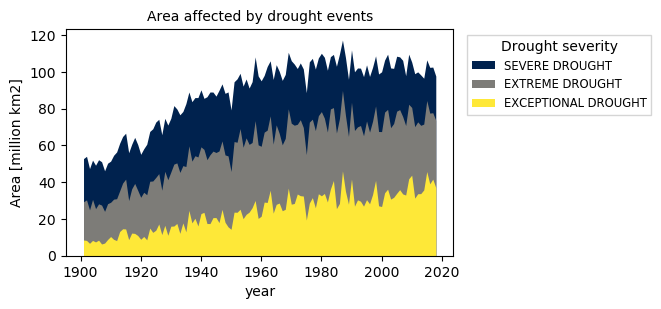

In [46]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(5, 3))
plot_data = (drought_area_ts / 1e6)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[2:]]
plot_data.plot.area(stacked=False, linewidth=0, colormap='cividis', alpha=1,
                                                  legend=False,
                                                  ax=ax, label='Drought severity')
ax.legend(title='Drought severity', bbox_to_anchor=(1.02,1), loc="upper left", fancybox=False)
ax.set(
    title='Area affected by drought events',
    ylabel = 'Area [million km2]')

f.savefig(RESULTS_FOLDER / 'drought_area_spei.png')

[Text(0, 0.5, '% of land area'),
 Text(0.5, 1.0, 'Area affected by drought events')]

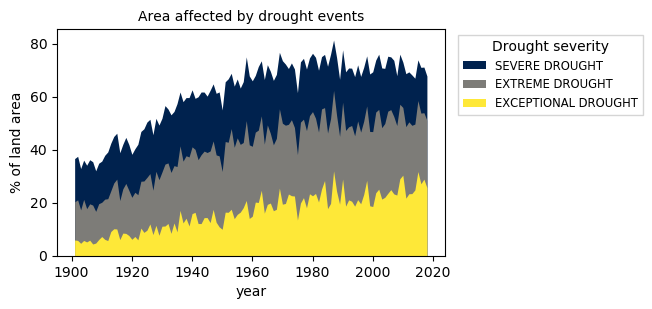

In [28]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(5, 3))
plot_data = (100*drought_area_ts / total_land_area)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[2:]]
plot_data.plot.area(stacked=False, linewidth=0, colormap='cividis', alpha=1,
                                                  legend=False,
                                                  ax=ax, label='Drought severity')
ax.legend(title='Drought severity', bbox_to_anchor=(1.02,1), loc="upper left", fancybox=False)
ax.set(
    title='Area affected by drought events',
    ylabel = '% of land area')

f.savefig(RESULTS_FOLDER / 'drought_percent_area_spei.png')

In [93]:
drought_area_ts.to_csv(RESULTS_FOLDER / 'drought_total_area_spei.csv')

(drought_area_ts / total_land_area).to_csv(RESULTS_FOLDER / 'drought_percent_area_spei.csv')

# Calculate Mean and SD of droughts during baseline period and plot relative to this

The idea is that we care about events that are more unusual also relative to the typical variation. So if we consider the 'normal' spread of drought events during the reference period, then we want to see what areas are in the extreme ranges of this.


In [41]:
drought_counts_mean = drought_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year').compute()
drought_counts_std = drought_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).std(dim='year').compute()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [30]:
# (drought_counts_mean.hvplot.contourf(
#     'longitude', 'latitude', projection=MAP_PROJECTION, project=True, global_extent=True, 
#     cmap='plasma', rasterize=False, dynamic=True, coastline=True, 
#     frame_width=380
# ) 
#  + drought_counts_std.hvplot.contourf(
#     'longitude', 'latitude', projection=MAP_PROJECTION, project=True, global_extent=True, 
#     cmap='plasma', rasterize=False, dynamic=True, coastline=True, 
#     frame_width=380
#  ))

## Plot events where the count is over 2 SD above the mean

> Showing only data every few years to avoid overloading the browser

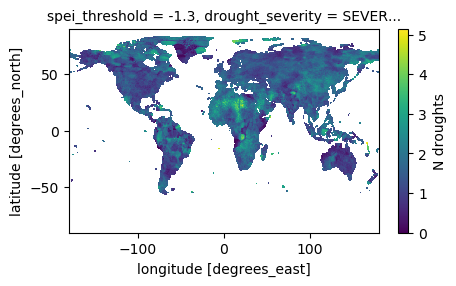

In [40]:
drought_counts_mean.sel(spei_threshold=SEVERE_DROUGHT_THRESHOLD).plot()

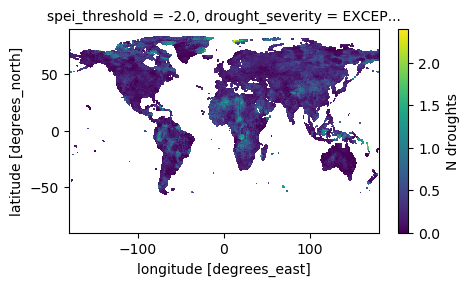

In [41]:
drought_counts_mean.sel(spei_threshold=EXCEPTIONAL_DROUGHT_THRESHOLD).plot()

In [42]:
drought_over_2std = (drought_counts > (drought_counts_mean + 2*drought_counts_std)).astype(int)
drought_over_2std = drought_over_2std.where(mask)

In [43]:
# # Select few years otherwise chokes up HvPlot
# years = list(range(1980, MAX_YEAR+1, 10))
# years.append(MAX_YEAR)

# drought_over_2std.sel(year=years).hvplot.contourf(
#     'longitude', 'latitude', 
#     projection=MAP_PROJECTION, 
#     project=True, global_extent=True, 
#     cmap='Reds',
# #     rasterize=True, 
#     dynamic=False, 
#     coastline=True, 
#     frame_width=500)

In [69]:
import matplotlib.colors as colors

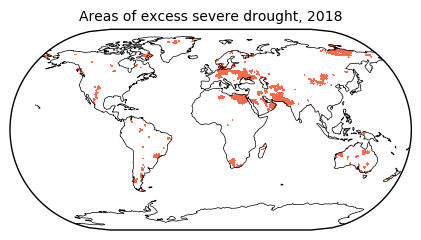

In [44]:

plot_data = drought_over_2std.sel(year=2018,spei_threshold=SEVERE_DROUGHT_THRESHOLD)
plot_data = plot_data.where(plot_data >0)

f, ax = plt.subplots(figsize=(6,2.5), subplot_kw=dict(projection=MAP_PROJECTION))

plot_data.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),

    add_colorbar=False,
    #     norm=n
#     levels=[0,1, 1.001],
#     cbar_kwargs=dict(label='In drought'),
        cmap='Reds_r',
#     vmin=1, vmax=1
)
ax.coastlines(linewidth=0.5)
ax.set(title=f'Areas of excess severe drought, {MAX_YEAR}')
ax.set_global()

plt.tight_layout()

# f.savefig(RESULTS_FOLDER/f'map_droughts_spei_over_2sd_{MAX_YEAR}.png')
# f.savefig(RESULTS_FOLDER/f'map_droughts_spei_over_2sd_{MAX_YEAR}.pdf')

f.show()


In [52]:

# plot_data = drought_over_2std.sel(year=2018,spei_threshold=MILD_DROUGHT_THRESHOLD)
# plot_data = plot_data.where(plot_data >0)

# f, ax = plt.subplots(figsize=(6,2.5), subplot_kw=dict(projection=MAP_PROJECTION))

# plot_data.plot.contourf(
#     ax=ax,
#     transform=ccrs.PlateCarree(),

#     add_colorbar=False,
#         cmap='Reds_r',
# )
# ax.coastlines(linewidth=0.5)
# ax.set(title=f'Areas of excess severe drought, {MAX_YEAR}')
# ax.set_global()

# plt.tight_layout()

# # f.savefig(RESULTS_FOLDER/f'map_droughts_spei_over_2sd_{MAX_YEAR}.png')
# # f.savefig(RESULTS_FOLDER/f'map_droughts_spei_over_2sd_{MAX_YEAR}.pdf')

# f.show()


In [94]:
drought_over_2std.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'drought_excess_spei.nc')

### % area excess drought

In [45]:
drought_area_ts_2sd = drought_over_2std * areas

drought_area_ts_2sd = (drought_area_ts_2sd
                   .sum(dim=['latitude', 'longitude'])
                   .to_dataframe(name='km2')
                   .reset_index()
                   .set_index(['drought_severity', 'year'])['km2']
                   .unstack().T
                  )
# Overkill categorical columns :P
drought_area_ts_2sd.columns = drought_area_ts_2sd.columns.astype(
    pd.CategoricalDtype(DROUGHT_THRESHOLDS_NAMES, ordered=True))

drought_area_ts_2sd = drought_area_ts_2sd.sort_index(axis=1, ascending=True)

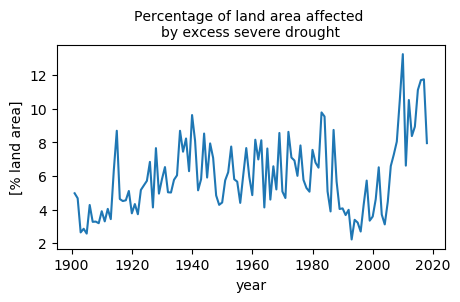

In [38]:
plot_data = drought_area_ts_2sd['SEVERE DROUGHT']

ax = (100*plot_data / total_land_area).plot()


ax.set(
    ylabel='[% land area]',
    title='Percentage of land area affected \nby excess severe drought',
#     ylim=(0,1.5)
)
# ax.figure.savefig(RESULTS_FOLDER / 'pct_area_excess_severe_drought.png')
ax.figure.show()

[Text(0, 0.5, 'Area [million km2]'),
 Text(0.5, 1.0, 'Area affected by excess drought events')]

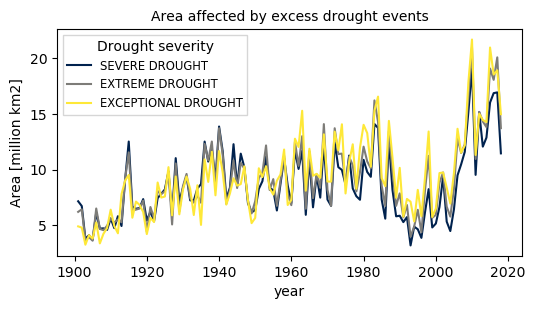

In [46]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(6, 3))
plot_data = (drought_area_ts_2sd / 1e6)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[2:]]

plot_data.plot(
#     stacked=False, 
#     linewidth=0, 
    colormap='cividis', alpha=1,
    ax=ax,
    legend=False
)

ax.legend(title='Drought severity',
#           bbox_to_anchor=(1.02,1), loc="upper left", 
          fancybox=False
         )
ax.set(title='Area affected by excess drought events',
       ylabel = 'Area [million km2]')

# f.savefig(RESULTS_FOLDER / 'drought_excess_area_spei.png')

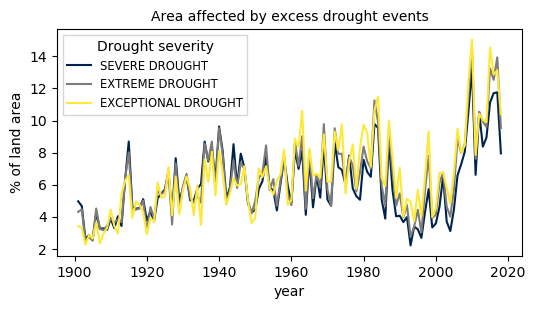

In [117]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(6, 3))
plot_data = (100*drought_area_ts_2sd / total_land_area)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[2:]]

plot_data.plot(
#     stacked=False, 
#     linewidth=0, 
    colormap='cividis', alpha=1,
    ax=ax,
    legend=False
)

ax.legend(title='Drought severity',
#           bbox_to_anchor=(1.02,1), loc="upper left", 
          fancybox=False
         )
ax.set(title='Area affected by excess drought events',
       ylabel = '% of land area')

f.savefig(RESULTS_FOLDER / 'drought_excess_percent_area_spei.png')

In [95]:
drought_area_ts_2sd.to_csv(RESULTS_FOLDER / 'drought_excess_total_area_spei.csv')

(drought_area_ts_2sd / total_land_area).to_csv(RESULTS_FOLDER / 'drought_excess_percent_area_spei.csv')

# Compare with Marina's results

In [10]:
marina_global_total = pd.read_csv('unfiltered global total area under threshold.csv').set_index('Year')

In [11]:
marina_signif_total = pd.read_csv('significant total and percentage global area under threshold.csv').set_index('Year')

## Areas for events over 2sd

In [24]:
DROUGHT_THRESHOLDS[2:]

[-1.3, -1.6, -2]

[Text(0, 0.5, 'Area [million km2]'),
 Text(0.5, 1.0, 'Area affected by excess drought events')]

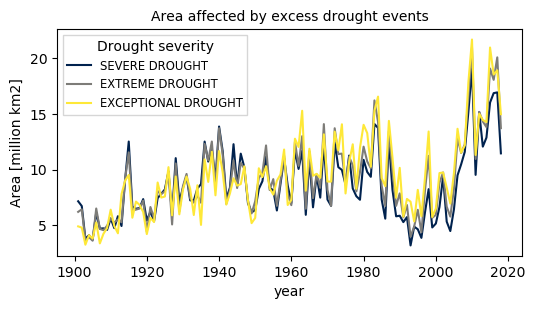

In [46]:
# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(6, 3))
plot_data = (drought_area_ts_2sd / 1e6)
plot_data = plot_data[DROUGHT_THRESHOLDS_NAMES[2:]]

plot_data.plot(
#     stacked=False, 
#     linewidth=0, 
    colormap='cividis', alpha=1,
    ax=ax,
    legend=False
)

ax.legend(title='Drought severity',
#           bbox_to_anchor=(1.02,1), loc="upper left", 
          fancybox=False
         )
ax.set(title='Area affected by excess drought events',
       ylabel = 'Area [million km2]')

# f.savefig(RESULTS_FOLDER / 'drought_excess_area_spei.png')

[Text(0, 0.5, 'Area [million km2]'),
 Text(0.5, 1.0, 'Area affected by excess drought events')]

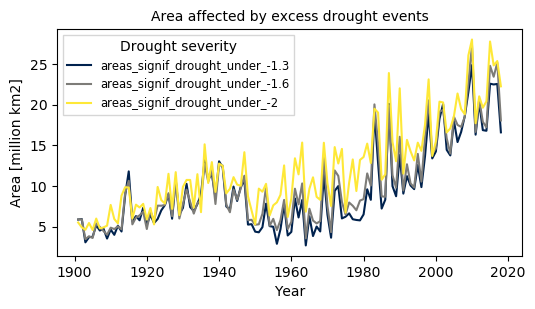

In [28]:
cols = ['areas_signif_drought_under_-1.3',
        'areas_signif_drought_under_-1.6',
       'areas_signif_drought_under_-2',]

# drought_area_ts = drought_area_ts.sort_index(axis=1, ascending=False)
f, ax = plt.subplots(figsize=(6, 3))
plot_data = (marina_signif_total / 1e6)

plot_data = plot_data[cols]

plot_data.plot(
#     stacked=False, 
#     linewidth=0, 
    colormap='cividis', alpha=1,
    ax=ax,
    legend=False
)

ax.legend(title='Drought severity',
#           bbox_to_anchor=(1.02,1), loc="upper left", 
          fancybox=False
         )
ax.set(title='Area affected by excess drought events',
       ylabel = 'Area [million km2]')
